In [1]:
from pprint import pprint
import time
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import csv
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import math
import json

# Portugal Stock Data

In [2]:
curr_time = int(time.time())
#prior_year = curr_time-(60*60*24*365)
prior_year = 1543622400  # unix for December 01,2018
ticker_symbol = "PGAL"

In [3]:

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "c9571a29b7msh7dedf518d9ba8b2p1bf4b5jsnec4ec11b7588"
    }

response = requests.request("GET", url, headers=headers, params=querystring)


C:\Users\nateb\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


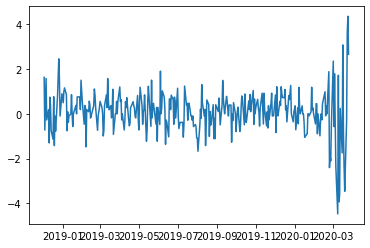

In [4]:
timestamp = response.json()['chart']['result'][0]['timestamp']
year_close = response.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

    
pgalDict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
pgal_df = pd.DataFrame(pgalDict)

pgal_df['Change %'] = ((pgal_df['Close']-pgal_df['Open'])/pgal_df['Open'])*100

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(pgal_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(pgal_df['Timestamp']))]
pgal_df['Date'] = convert_date


pgal_df['Last Year'] =[datetime.datetime.strptime(pgal_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(pgal_df['Date']))]
pgal_df['Date']=pd.to_datetime(pgal_df['Date'],errors='coerce')

pgal_df2=pgal_df.sort_values(by='Date',ascending=False)
pgal_df2=pgal_df.head(59)

plt.plot(pgal_df['Date'],pgal_df['Change %'])
plt.show()

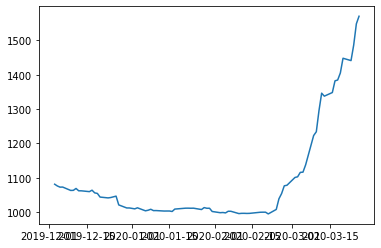

In [5]:
volatile_yr_avg = []
yearlyGroups = []
yearlyTimestamp = []

for i in range(0,len(pgal_df['Timestamp'])):
    try:
        cond1 = pgal_df['Timestamp']<=pgal_df['Timestamp'][i]
        cond2 = (pd.Series(pgal_df['Timestamp']>=(pgal_df['Timestamp'][i]-(365*24*60*60))))
        df = pgal_df[cond1 & cond2]
        #print('working')
        if len(df)>251:  #avoids sets less than a full year
            volatile_yr_avg.append(df.std()['Change %']*math.sqrt(len(df))*100) #annual volatility (stdev * sqrt(252))
            yearlyGroups.append(pgal_df['Date'][i]) 
            yearlyTimestamp.append(pgal_df['Timestamp'][i])
            
    except:
        print('Error Found')
volatile_pgal_dict = {"Date":yearlyGroups,
                    "Annual Volatility":volatile_yr_avg,
                     "Timestamp":yearlyTimestamp
                    }
volatile_pgal_df = pd.DataFrame(volatile_pgal_dict)
volatile_pgal_df['Date']=pd.to_datetime(volatile_pgal_df['Date'])
pgal_volatility=volatile_pgal_df.sort_values(by='Date',ascending=False)
pgal_volatility=pgal_volatility.head(59)

# volatile_pgal_df.dtypes
plt.plot(volatile_pgal_df['Date'],volatile_pgal_df['Annual Volatility'])

# DJI Index

In [6]:
curr_time = int(time.time())
ticker_symbol = "^DJI"
prior_year=1543622400
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "c9571a29b7msh7dedf518d9ba8b2p1bf4b5jsnec4ec11b7588"
    }

response_DJI = requests.request("GET", url, headers=headers, params=querystring)

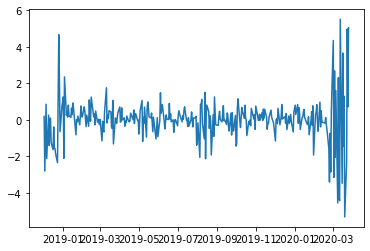

In [7]:
timestamp = response_DJI.json()['chart']['result'][0]['timestamp']
year_close = response_DJI.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response_DJI.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response_DJI.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response_DJI.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

dji_Dict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
dji_df = pd.DataFrame(dji_Dict)

dji_df['Change %'] = ((dji_df['Close']-dji_df['Open'])/dji_df['Open'])*100

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(dji_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(dji_df['Timestamp']))]
dji_df['Date'] = convert_date


dji_df['Last Year'] =[datetime.datetime.strptime(dji_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(dji_df['Date']))]
dji_df['Date']=pd.to_datetime(dji_df['Date'],errors='coerce')

plt.plot(dji_df['Date'],dji_df['Change %'])
plt.show()
# dji_df.dtypes

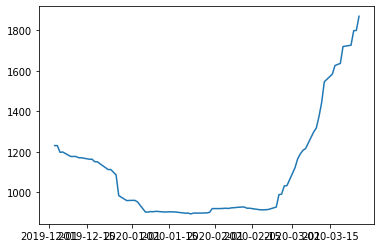

In [8]:
volatile_yr_avg = []
yearlyGroups = []
yearlyTimestamp = []

for i in range(0,len(dji_df['Timestamp'])):
    try:
        cond1 = dji_df['Timestamp']<=dji_df['Timestamp'][i]
        cond2 = (pd.Series(dji_df['Timestamp']>=(dji_df['Timestamp'][i]-(365*24*60*60))))
        df = dji_df[cond1 & cond2]
        #print('working')
        if len(df)>251:  #avoids sets less than a full year
            volatile_yr_avg.append(df.std()['Change %']*math.sqrt(len(df))*100) #annual volatility (stdev * sqrt(252))
            yearlyGroups.append(dji_df['Date'][i]) 
            yearlyTimestamp.append(dji_df['Timestamp'][i])
            
    except:
        print('Error Found')
volatile_dji_dict = {"Date":yearlyGroups,
                    "Annual Volatility":volatile_yr_avg,
                     "Timestamp":yearlyTimestamp
                    }
volatile_dji_df = pd.DataFrame(volatile_dji_dict)
volatile_dji_df['Date']=pd.to_datetime(volatile_dji_df['Date'])
# volatile_dji_df.dtypes


plt.plot(volatile_dji_df['Date'],volatile_dji_df['Annual Volatility'])

# S&P 500 Index

In [9]:
curr_time = int(time.time())
#prior_year = curr_time-(60*60*24*365)
prior_year=1543622400
ticker_symbol = "^GSPC"


url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "c9571a29b7msh7dedf518d9ba8b2p1bf4b5jsnec4ec11b7588"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

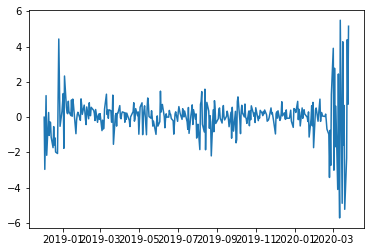

In [10]:
timestamp = response.json()['chart']['result'][0]['timestamp']
year_close = response.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

    
snpDict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
snp_df = pd.DataFrame(snpDict)

snp_df['Change %'] = ((snp_df['Close']-snp_df['Open'])/snp_df['Open'])*100

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(snp_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(snp_df['Timestamp']))]
snp_df['Date'] = convert_date


snp_df['Last Year'] =[datetime.datetime.strptime(snp_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(snp_df['Date']))]
snp_df['Date']=pd.to_datetime(snp_df['Date'],errors='coerce')

# snp_df.tail()
plt.plot(snp_df['Date'],snp_df['Change %'])
plt.show()

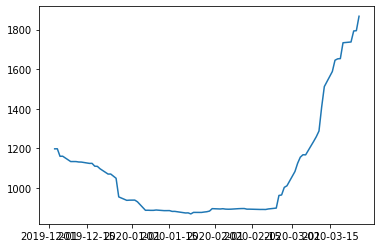

In [11]:
volatile_yr_avg = []
yearlyGroups = []
yearlyTimestamp = []

for i in range(0,len(snp_df['Timestamp'])):
    try:
        cond1 = snp_df['Timestamp']<=snp_df['Timestamp'][i]
        cond2 = (pd.Series(snp_df['Timestamp']>=(snp_df['Timestamp'][i]-(365*24*60*60))))
        df = snp_df[cond1 & cond2]
        #print('working')
        if len(df)>251:  #avoids sets less than a full year
            volatile_yr_avg.append(df.std()['Change %']*math.sqrt(len(df))*100) #annual volatility (stdev * sqrt(252))
            yearlyGroups.append(snp_df['Date'][i]) 
            yearlyTimestamp.append(snp_df['Timestamp'][i])
            
    except:
        print('Error Found')
volatile_snp_dict = {"Date":yearlyGroups,
                    "Annual Volatility":volatile_yr_avg,
                     "Timestamp":yearlyTimestamp
                    }
volatile_snp_df = pd.DataFrame(volatile_snp_dict)
volatile_snp_df['Date']=pd.to_datetime(volatile_snp_df['Date'])
snp_volatility=volatile_snp_df.sort_values(by='Date',ascending=False)
snp_volatility=snp_volatility.head(59)

snp_volatility.shape

plt.plot(volatile_snp_df['Date'],volatile_snp_df['Annual Volatility'])

# Italy Index

In [12]:
italy_df=pd.read_csv("italy_index/FTSE Italia All Share Historical Data.csv")
italy_df.head()

,Date,Price,Open,High,Low,Vol.,Change %,Timestamp
0,2020-3-20,17171.55,17209.93,17628.87,17047.73,1500000000,1.85,1584662400
1,2020-3-19,16859.82,16814.38,17240.13,16438.49,1270000000,2.27,1584576000
2,2020-3-18,16486.21,16372.27,16785.57,16149.48,992760000,-1.17,1584489600
3,2020-3-17,16680.56,16850.34,17238.59,16065.72,1400000000,1.96,1584403200
4,2020-3-16,16360.04,17130.96,17130.96,15498.19,1540000000,-6.06,1584316800


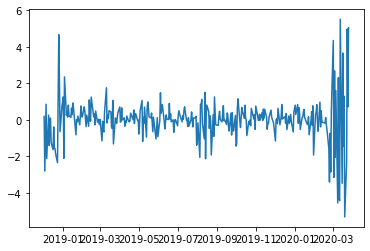

In [13]:
timestamp = response_DJI.json()['chart']['result'][0]['timestamp']
year_close = response_DJI.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response_DJI.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response_DJI.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response_DJI.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

italy_Dict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
italy_df = pd.DataFrame(italy_Dict)

italy_df['Change %'] = ((italy_df['Close']-italy_df['Open'])/italy_df['Open'])*100

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(italy_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(italy_df['Timestamp']))]
italy_df['Date'] = convert_date


italy_df['Last Year'] =[datetime.datetime.strptime(italy_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(dji_df['Date']))]
italy_df['Date']=pd.to_datetime(italy_df['Date'],errors='coerce')

plt.plot(italy_df['Date'],italy_df['Change %'])
plt.show()

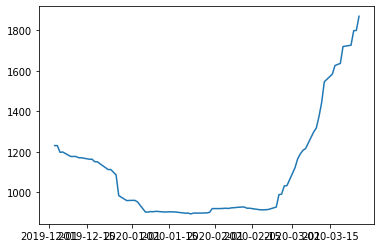

In [14]:
volatile_yr_avg = []
yearlyGroups = []
yearlyTimestamp = []

for i in range(0,len(dji_df['Timestamp'])):
    try:
        cond1 = italy_df['Timestamp']<=italy_df['Timestamp'][i]
        cond2 = (pd.Series(italy_df['Timestamp']>=(italy_df['Timestamp'][i]-(365*24*60*60))))
        df = dji_df[cond1 & cond2]
        #print('working')
        if len(df)>251:  #avoids sets less than a full year
            volatile_yr_avg.append(df.std()['Change %']*math.sqrt(len(df))*100) #annual volatility (stdev * sqrt(252))
            yearlyGroups.append(italy_df['Date'][i]) 
            yearlyTimestamp.append(italy_df['Timestamp'][i])
            
    except:
        print('Error Found')
volatile_italy_dict = {"Date":yearlyGroups,
                    "Annual Volatility":volatile_yr_avg,
                     "Timestamp":yearlyTimestamp
                    }
volatile_italy_df = pd.DataFrame(volatile_italy_dict)
volatile_italy_df['Date']=pd.to_datetime(volatile_italy_df['Date'])
volatile_italy_df.dtypes

plt.plot(volatile_italy_df['Date'],volatile_italy_df['Annual Volatility'])

# COVID DATA

In [15]:
time_series_2019_ncov_Deaths =pd.read_csv("COVID19_data/time_series_2019-ncov-Deaths.csv")
time_series_2019_ncov_Recovered = pd.read_csv("COVID19_data/time_series_2019-ncov-Recovered.csv")
time_series_2019_ncov_Confirmed = pd.read_csv("COVID19_data/time_series_2019-ncov-Confirmed.csv")
time_series_ncov_Recovered = pd.read_csv("COVID19_data/time_series-ncov-Recovered.csv")
time_series_ncov_Confirmed = pd.read_csv("COVID19_data/time_series-ncov-Confirmed.csv")
time_series_ncov_Deaths = pd.read_csv("COVID19_data/time_series-ncov-Deaths.csv")

# Italy Confirmed Cases

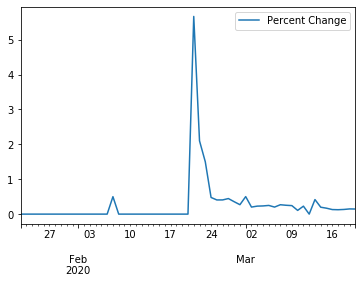

In [16]:
Italy_cond=time_series_2019_ncov_Confirmed['Country/Region']=='Italy'

Italy_confirmed = time_series_2019_ncov_Confirmed[Italy_cond]
Italy_confirmed =Italy_confirmed.drop(columns =['Lat','Long','Province/State'])
Italy_confirmed = Italy_confirmed.groupby('Country/Region').sum()

Italy_confirmed =Italy_confirmed.T
Italy_confirmed.index = pd.to_datetime(Italy_confirmed.index)
#china_confirmed.plot(legend=False)

Italy_daily = [0]
Italy_daily_percent = [0]
for i in range(1,len(Italy_confirmed['Italy'])):
    Italy_daily.append(Italy_confirmed['Italy'][i]-Italy_confirmed['Italy'][i-1])
    if Italy_confirmed['Italy'][i-1]>0:
        Italy_daily_percent.append((Italy_confirmed['Italy'][i]-Italy_confirmed['Italy'][i-1])/Italy_confirmed['Italy'][i-1])
    else:
        Italy_daily_percent.append(0)
        
Italy_daily_df = Italy_confirmed[['Italy']]
Italy_daily_df['Daily']=Italy_daily
Italy_daily_df['Percent Change'] = Italy_daily_percent
Italy_daily_plot = Italy_daily_df['Daily']
#china_daily_plot.plot(legend=False)
Italy_daily_df['Percent Change'].plot(legend=True)
plt.show()

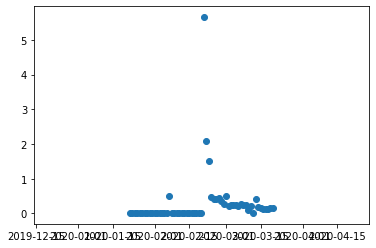

In [17]:
plt.scatter(Italy_daily_df.reset_index()['index'],Italy_daily_df.reset_index()['Percent Change'])

# US Confirmed Cases

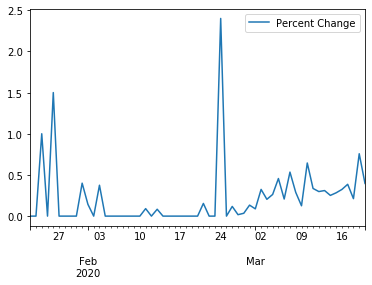

In [18]:
us_cond=time_series_2019_ncov_Confirmed['Country/Region']=='US'

us_confirmed = time_series_2019_ncov_Confirmed[us_cond]
us_confirmed =us_confirmed.drop(columns =['Lat','Long','Province/State'])
us_confirmed = us_confirmed.groupby('Country/Region').sum()

us_confirmed =us_confirmed.T
us_confirmed.index = pd.to_datetime(us_confirmed.index)
#us_confirmed.plot(legend=True,label = "Total Cases")

us_daily = [0]
us_daily_percent = [0]
for i in range(1,len(us_confirmed['US'])):
    us_daily.append(us_confirmed['US'][i]-us_confirmed['US'][i-1])
    if us_confirmed['US'][i-1]>0:
        us_daily_percent.append((us_confirmed['US'][i]-us_confirmed['US'][i-1])/us_confirmed['US'][i-1])
    else:
        us_daily_percent.append(0)
us_daily_df = us_confirmed[['US']]
us_daily_df['Daily']=us_daily
us_daily_df['Percent Change'] = us_daily_percent

#us_daily_plot = us_daily_df['Daily']
#us_daily_plot.plot(legend=False,label = "Daily Cases")
us_daily_df['Percent Change'].plot(legend=True)
plt.legend()
plt.show()

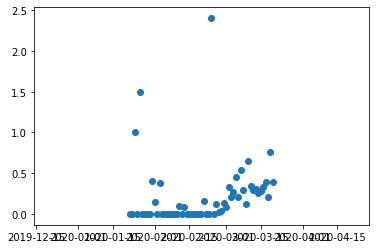

In [19]:
plt.scatter(us_daily_df.reset_index()['index'],us_daily_df.reset_index()['Percent Change'])


# China Confirmed Cases

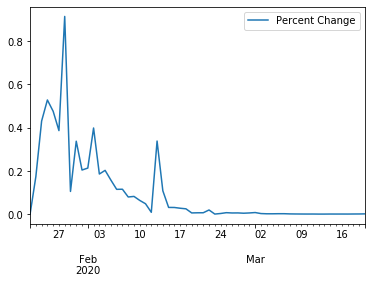

In [20]:
china_cond=time_series_2019_ncov_Confirmed['Country/Region']=='China'

china_confirmed = time_series_2019_ncov_Confirmed[china_cond]
china_confirmed =china_confirmed.drop(columns =['Lat','Long','Province/State'])
china_confirmed = china_confirmed.groupby('Country/Region').sum()

china_confirmed =china_confirmed.T
china_confirmed.index = pd.to_datetime(china_confirmed.index)
#us_confirmed.plot(legend=True,label = "Total Cases")

china_daily = [0]
china_daily_percent = [0]
for i in range(1,len(china_confirmed['China'])):
    china_daily.append(china_confirmed['China'][i]-china_confirmed['China'][i-1])
    if china_confirmed['China'][i-1]>0:
        china_daily_percent.append((china_confirmed['China'][i]-china_confirmed['China'][i-1])/china_confirmed['China'][i-1])
    else:
        china_daily_percent.append(0)
china_daily_df = china_confirmed[['China']]
china_daily_df['Daily']=china_daily
china_daily_df['Percent Change'] = china_daily_percent

#us_daily_plot = us_daily_df['Daily']
#us_daily_plot.plot(legend=False,label = "Daily Cases")
china_daily_df['Percent Change'].plot(legend=True)
plt.legend()
plt.show()

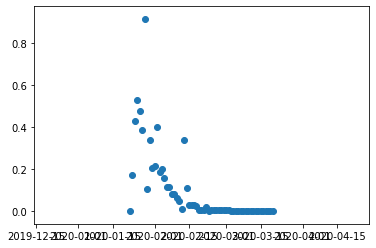

In [21]:
plt.scatter(china_daily_df.reset_index()['index'],china_daily_df.reset_index()['Percent Change'])

# Data Visuals

# PGAL v COVID Cases

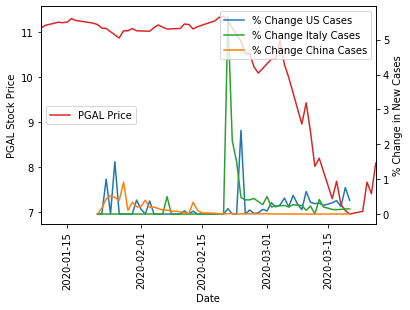

In [22]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('PGAL Stock Price')
ax1.plot(pgal_df['Date'],pgal_df['Close'], label = "PGAL Price", color=color)
plt.xlim(datetime.date(2020,1,9),datetime.date(2020,3,26))
#plt.yscale('symlog')

plt.legend(loc='center left')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:orange'
ax2.set_ylabel('% Change in New Cases')
ax2.plot(us_daily_df['Percent Change'], label = "% Change US Cases", color=color1)
ax2.plot(Italy_daily_df['Percent Change'], label = "% Change Italy Cases", color=color2)
ax2.plot(china_daily_df['Percent Change'], label = "% Change China Cases", color=color3)

plt.legend(loc = 'upper right')

plt.show()

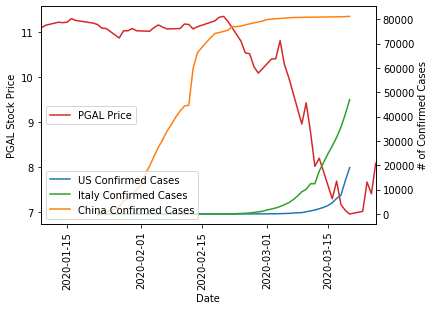

In [23]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('PGAL Stock Price')
ax1.plot(pgal_df['Date'],pgal_df['Close'], label = "PGAL Price", color=color)
plt.xlim(datetime.date(2020,1,9),datetime.date(2020,3,26))
#plt.yscale('symlog')

plt.legend(loc='center left')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:orange'
ax2.set_ylabel('# of Confirmed Cases')
ax2.plot(us_confirmed['US'], label = "US Confirmed Cases", color=color1)
ax2.plot(Italy_confirmed['Italy'], label = "Italy Confirmed Cases", color=color2)
ax2.plot(china_confirmed['China'], label = "China Confirmed Cases", color=color3)

plt.legend(loc = 'lower left')

plt.show()

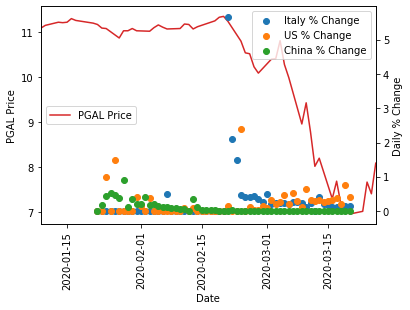

In [24]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('PGAL Price')
ax1.plot(pgal_df['Date'],pgal_df['Close'], label = "PGAL Price", color=color)
plt.xlim(datetime.date(2020,1,9),datetime.date(2020,3,26))

plt.legend(loc='center left')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:orange'
ax2.set_ylabel('Daily % Change')
ax2.scatter(Italy_daily_df.reset_index()['index'],Italy_daily_df.reset_index()['Percent Change'],label='Italy % Change')
ax2.scatter(us_daily_df.reset_index()['index'],us_daily_df.reset_index()['Percent Change'], label='US % Change')
ax2.scatter(china_daily_df.reset_index()['index'],china_daily_df.reset_index()['Percent Change'],label='China % Change')

plt.legend(loc = 'best')
plt.show()

# Dow Jones v COVID Cases

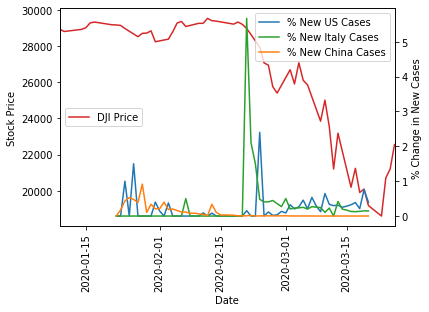

In [25]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price')
ax1.plot(dji_df['Date'],dji_df['Close'], label = "DJI Price", color=color)
plt.xlim(datetime.date(2020,1,9),datetime.date(2020,3,26))
#plt.yscale('symlog')

plt.legend(loc='center left')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:orange'
ax2.set_ylabel('% Change in New Cases')
ax2.plot(us_daily_df['Percent Change'], label = "% New US Cases", color=color1)
ax2.plot(Italy_daily_df['Percent Change'], label = "% New Italy Cases", color=color2)
ax2.plot(china_daily_df['Percent Change'], label = "% New China Cases", color=color3)

plt.legend(loc = 'upper right')

plt.show()

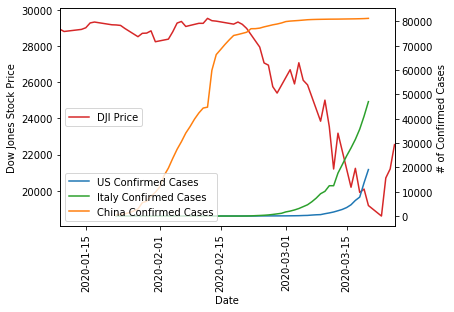

In [26]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Dow Jones Stock Price')
ax1.plot(dji_df['Date'],dji_df['Close'], label = "DJI Price", color=color)
plt.xlim(datetime.date(2020,1,9),datetime.date(2020,3,26))
#plt.yscale('symlog')

plt.legend(loc='center left')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:orange'
ax2.set_ylabel('# of Confirmed Cases')
ax2.plot(us_confirmed['US'], label = "US Confirmed Cases", color=color1)
ax2.plot(Italy_confirmed['Italy'], label = "Italy Confirmed Cases", color=color2)
ax2.plot(china_confirmed['China'], label = "China Confirmed Cases", color=color3)

plt.legend(loc = 'lower left')

plt.show()

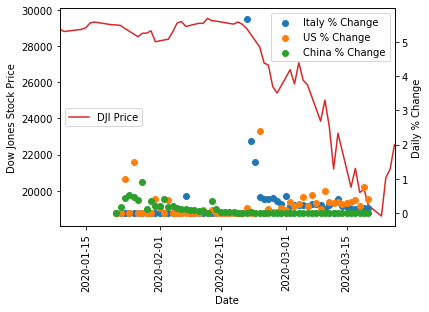

In [27]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Dow Jones Stock Price')
ax1.plot(dji_df['Date'],dji_df['Close'], label = "DJI Price", color=color)
plt.xlim(datetime.date(2020,1,9),datetime.date(2020,3,26))

plt.legend(loc='center left')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:orange'
ax2.set_ylabel('Daily % Change')
ax2.scatter(Italy_daily_df.reset_index()['index'],Italy_daily_df.reset_index()['Percent Change'],label='Italy % Change')
ax2.scatter(us_daily_df.reset_index()['index'],us_daily_df.reset_index()['Percent Change'], label='US % Change')
ax2.scatter(china_daily_df.reset_index()['index'],china_daily_df.reset_index()['Percent Change'],label='China % Change')

plt.legend(loc = 'best')
plt.show()

# Italy Markets v COVID Cases

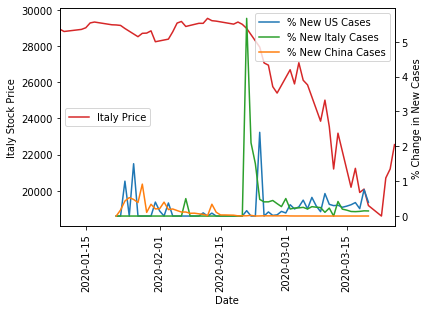

In [28]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Italy Stock Price')
ax1.plot(italy_df['Date'],italy_df['Close'], label = "Italy Price", color=color)
plt.xlim(datetime.date(2020,1,9),datetime.date(2020,3,26))
#plt.yscale('symlog')

plt.legend(loc='center left')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:orange'
ax2.set_ylabel('% Change in New Cases')
ax2.plot(us_daily_df['Percent Change'], label = "% New US Cases", color=color1)
ax2.plot(Italy_daily_df['Percent Change'], label = "% New Italy Cases", color=color2)
ax2.plot(china_daily_df['Percent Change'], label = "% New China Cases", color=color3)

plt.legend(loc = 'upper right')

plt.show()

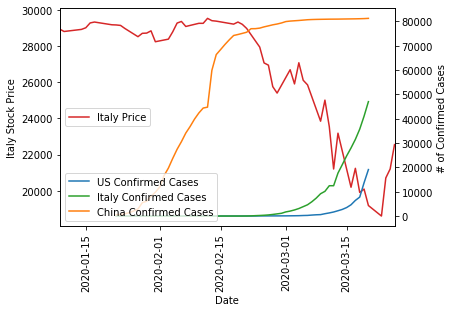

In [29]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Italy Stock Price')
ax1.plot(italy_df['Date'],italy_df['Close'], label = "Italy Price", color=color)
plt.xlim(datetime.date(2020,1,9),datetime.date(2020,3,26))
#plt.yscale('symlog')

plt.legend(loc='center left')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:orange'
ax2.set_ylabel('# of Confirmed Cases')
ax2.plot(us_confirmed['US'], label = "US Confirmed Cases", color=color1)
ax2.plot(Italy_confirmed['Italy'], label = "Italy Confirmed Cases", color=color2)
ax2.plot(china_confirmed['China'], label = "China Confirmed Cases", color=color3)

plt.legend(loc = 'lower left')

plt.show()

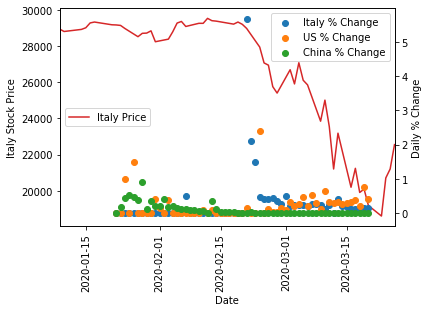

In [30]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Italy Stock Price')
ax1.plot(italy_df['Date'],italy_df['Close'], label = "Italy Price", color=color)
plt.xlim(datetime.date(2020,1,9),datetime.date(2020,3,26))

plt.legend(loc='center left')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:orange'
ax2.set_ylabel('Daily % Change')
ax2.scatter(Italy_daily_df.reset_index()['index'],Italy_daily_df.reset_index()['Percent Change'],label='Italy % Change')
ax2.scatter(us_daily_df.reset_index()['index'],us_daily_df.reset_index()['Percent Change'], label='US % Change')
ax2.scatter(china_daily_df.reset_index()['index'],china_daily_df.reset_index()['Percent Change'],label='China % Change')

plt.legend(loc = 'best')
plt.show()

# ARIMA MODEL

p-value: 3.5874739222371155e-06


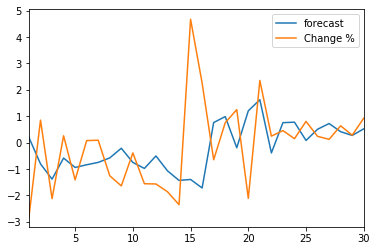

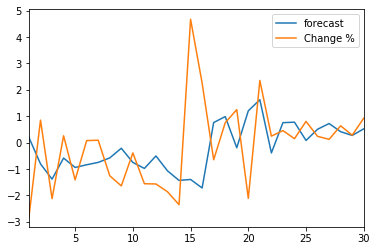

In [31]:
timeseries1=italy_df['Change %']
print("p-value:",adfuller(timeseries1.dropna())[1])

model=ARIMA(timeseries1,order=(5,1,0))
results=model.fit()
results.plot_predict(1,30)

p-value: 0.013010982558714763


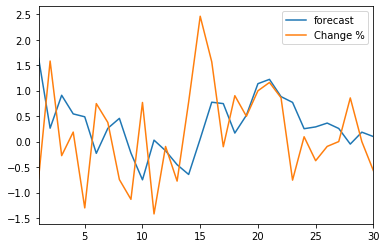

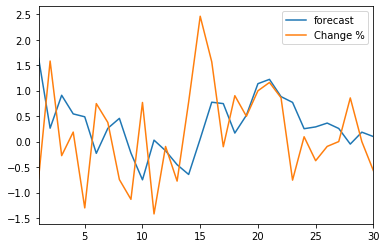

In [32]:
timeseries2=pgal_df['Change %']
print("p-value:",adfuller(timeseries2.dropna())[1])

model=ARIMA(timeseries2,order=(5,1,0))
results=model.fit()
results.plot_predict(1,30)

p-value: 3.5874739222371155e-06


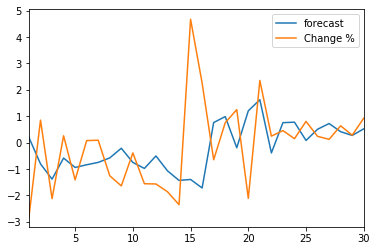

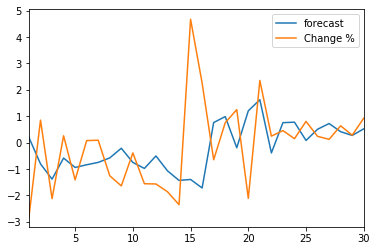

In [33]:
timeseries3=dji_df['Change %']
print("p-value:",adfuller(timeseries3.dropna())[1])

model=ARIMA(timeseries3,order=(5,1,0))
results=model.fit()
results.plot_predict(1,30)